In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Install necessary Packages
!pip install -q obspy
!pip install -q keras_tqdm

# Import all necessary Packages
import os
import time
import obspy
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
from obspy.io.segy.segy import _read_segy
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, clone_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Activation, Flatten, Dropout, Input

np.random.seed(42)
%matplotlib notebook

# Check if GPU is available
print(tf.test.is_gpu_available)

     |████████████████████████████████| 24.7MB 117kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


Using TensorFlow backend.


<function is_gpu_available at 0x7fe86a8a7400>


## Data Prepration

In [ ]:
filename = '/content/drive/My Drive/Public geoscience Data/Dutch F3 seismic data/Dutch Government_F3_entire_8bit seismic.segy'

t0=time.time()
stream0 = _read_segy(filename, headonly=True)
print('--> data read in {:.1f} sec'.format(time.time()-t0)) #Thanks to aadm 

t0=time.time()

labeled_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_in_line_number == 339).T
inline_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_in_line_number == 500).T
xline_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_cross_line_number == 500).T

print('--> created slices in {:.1f} sec'.format(time.time()-t0))

--> data read in 213.1 sec


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


--> created slices in 6.3 sec


In [ ]:
def patch_extractor2D(img,mid_x,mid_y,patch_size,dimensions=1):
    try:
        x,y,c = img.shape
    except ValueError:
        x,y = img.shape
        c=1
    patch= np.pad(img, patch_size//2, 'constant', constant_values=0)[mid_y:mid_y+patch_size,mid_x:mid_x+patch_size] #because it's padded we don't subtract half patches all the tim
    if c != dimensions:
        tmp_patch = np.zeros((patch_size,patch_size,dimensions))
        for uia in range(dimensions):
            tmp_patch[:,:,uia] = patch
        return tmp_patch
    return patch
image=np.random.rand(10,10)//.1
print(image)

patch_extractor2D(image,10,10,4,1)

[[ 3.  9.  7.  5.  1.  1.  0.  8.  6.  7.]
 [ 0.  9.  8.  2.  1.  1.  3.  5.  4.  2.]
 [ 6.  1.  2.  3.  4.  7.  1.  5.  5.  0.]
 [ 6.  1.  0.  9.  9.  8.  3.  0.  6.  4.]
 [ 1.  4.  0.  9.  2.  6.  3.  5.  5.  1.]
 [ 9.  7.  9.  8.  5.  9.  0.  1.  0.  3.]
 [ 3.  2.  8.  3.  2.  5.  1.  8.  0.  9.]
 [ 7.  1.  0.  8.  7.  7.  7.  0.  3.  1.]
 [ 8.  6.  3.  0.  3.  3.  7.  6.  8.  4.]
 [ 1.  7.  7.  5.  7.  4.  5.  4.  0.  1.]]


array([[ 8.,  4.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [ ]:
def acc_assess(data,loss=['categorical_crossentropy'],metrics=['acc']):
    if not isinstance(loss, list):
        try:
            loss = [loss]
        except:
            raise("Loss must be list.")
    if not isinstance(metrics, list):
        try:
            metrics = [metrics]
        except:
            raise("Metrics must be list.")
    out='The test loss is {:.3f}\n'.format(data[0])
    for i, metric in enumerate(metrics):            
        if metric in 'mae':
            out += "The total mean error on the test is {:.3f}\n".format(data[i+1])
        if metric in 'accuracy':
            out += "The test accuracy is {:.1f}%\n".format(data[i+1]*100)
    return out
print(acc_assess([1,2,3],'bla',["acc", "mae"]))

The test loss is 1.000
The test accuracy is 200.0%
The total mean error on the test is 3.000



In [ ]:
labels = pd.read_csv('/content/drive/My Drive/classificationlabel.ixz', delimiter=" ", names=["Inline","Xline","Time","Class"])
labels.describe()

,Inline,Xline,Time,Class
count,158812.0,158812.000000,158812.000000,158812.000000
mean,339.0,799.368782,1004.194016,4.084502
std,0.0,257.648696,478.899920,2.652356
min,339.0,300.000000,12.000000,0.000000
25%,339.0,583.000000,692.000000,2.000000
50%,339.0,827.000000,948.000000,4.000000
75%,339.0,1017.000000,1412.000000,6.000000
max,339.0,1250.000000,1848.000000,8.000000


In [ ]:
labels["Xline"]-=300-1
labels["Time"] = labels["Time"]//4
labels.describe()

,Inline,Xline,Time,Class
count,158812.0,158812.000000,158812.000000,158812.000000
mean,339.0,500.368782,251.048504,4.084502
std,0.0,257.648696,119.724980,2.652356
min,339.0,1.000000,3.000000,0.000000
25%,339.0,284.000000,173.000000,2.000000
50%,339.0,528.000000,237.000000,4.000000
75%,339.0,718.000000,353.000000,6.000000
max,339.0,951.000000,462.000000,8.000000


In [ ]:
labeled_data.shape

(462, 951)

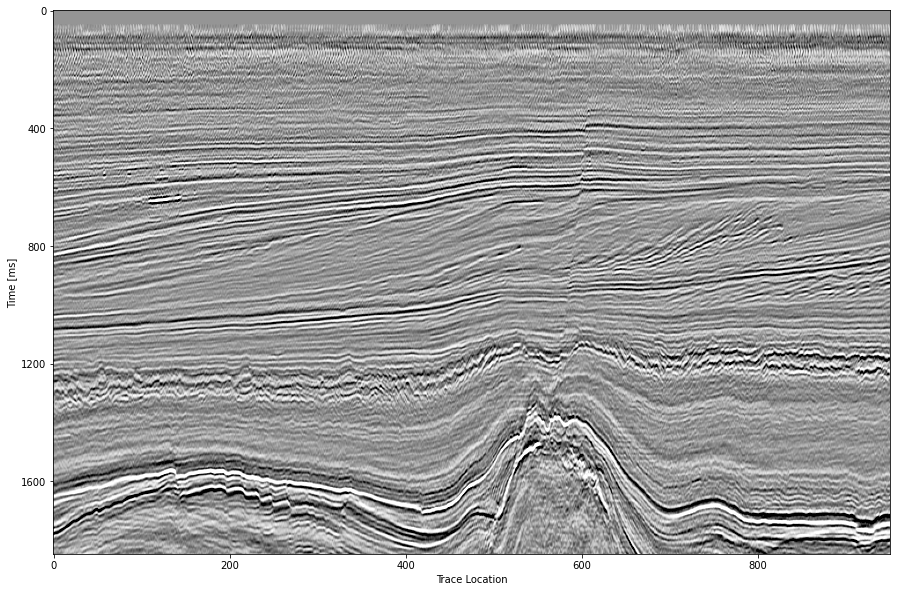

In [ ]:
%matplotlib inline
fig2 = plt.figure(figsize=(15.0, 10.0))
vml = np.percentile(labeled_data, 99)
img1 = plt.imshow(labeled_data, cmap="Greys", vmin=-vml, vmax=vml, aspect='auto')
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('labeled_data.png', bbox_inches='tight')
plt.show()

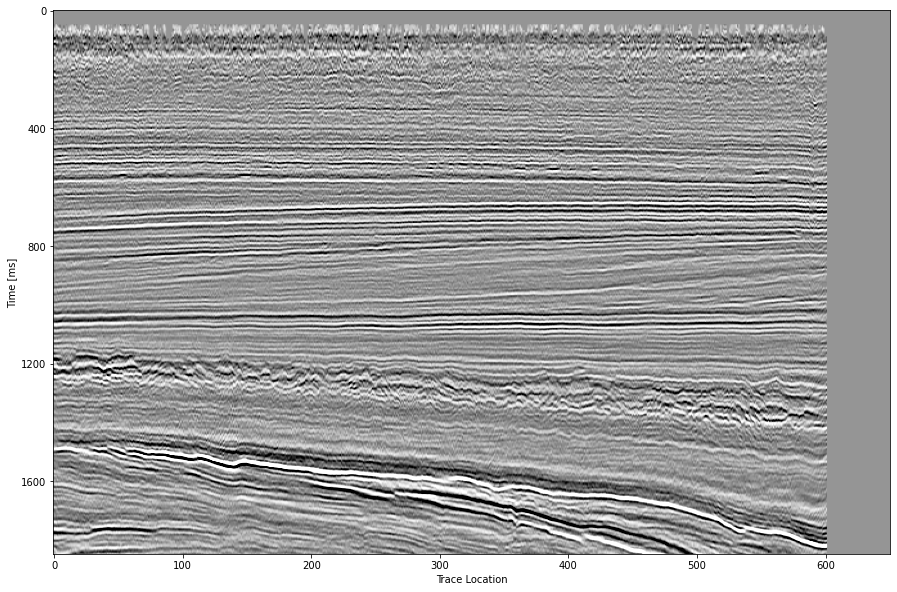

In [ ]:
fig2 = plt.figure(figsize=(15.0, 10.0))
vmx = np.percentile(xline_data, 99)
plt.imshow(xline_data, cmap="Greys", vmin=-vmx, vmax=vmx, aspect='auto')
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('xline_data.png', bbox_inches='tight')
plt.show()

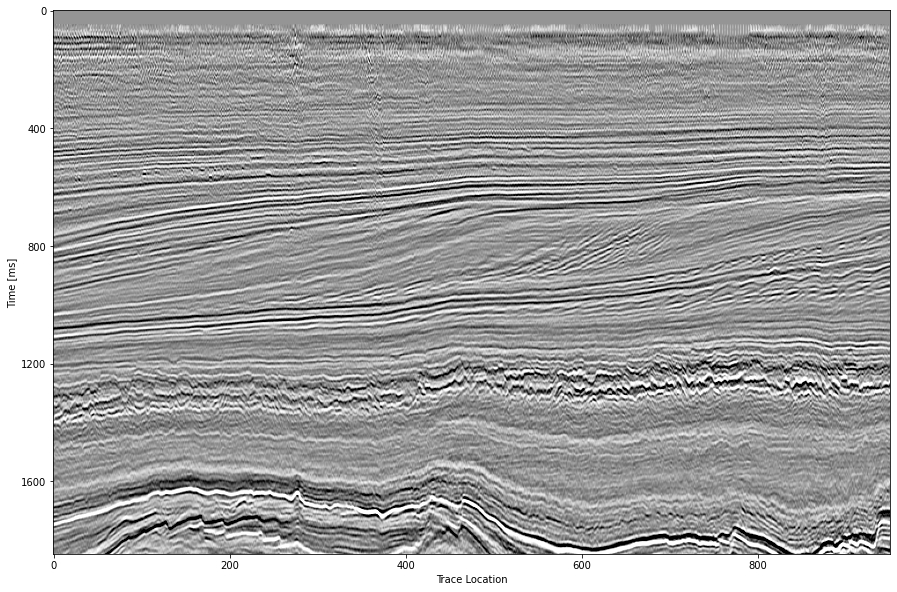

In [ ]:
fig2 = plt.figure(figsize=(15.0, 10.0))
vmy = np.percentile(inline_data, 99)
plt.imshow(inline_data, cmap="Greys", vmin=-vmy, vmax=vmy, aspect='auto')
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('inline_data.png', bbox_inches='tight')
plt.show()

In [ ]:
patch_size = 64 # for ResNet50 put 244
batch_size = 256
num_channels = 1
num_classes = 9
all_examples = 158812
num_examples = 7500
epochs = 20
steps=450
sampler = list(range(all_examples))

opt = 'adam'
lossfkt = ['categorical_crossentropy']
metrica = ['mae', 'acc']

In [ ]:
train_data, test_data, train_samples, test_samples = train_test_split(
    labels, sampler, random_state=42)
print(train_data.shape,test_data.shape)

(119109, 4) (39703, 4)


In [ ]:
class SeismicSequence(keras.utils.Sequence):
    def __init__(self, img, x_set, t_set, y_set, patch_size, batch_size, dimensions):
        self.slice = img
        self.X,self.t = x_set,t_set
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.dimensions = dimensions
        self.label = y_set
    
    def __len__(self):
        return len(self.X) // self.batch_size
    
    def __getitem__(self,idx):
        sampler = np.random.permutation(len(self.X))
        samples = sampler[idx*self.batch_size:(idx+1)*self.batch_size]
        labels = keras.utils.to_categorical(self.label[samples], num_classes=9)
        if self.dimensions == 1:
            return np.expand_dims(np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), axis=4), labels
        else:
            return np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), labels

In [ ]:
def patch_extractor2D(img,mid_x,mid_y,patch_size,dimensions=1):
    try:
        x,y,c = img.shape 
    except ValueError:
        x,y = img.shape
        c=1
    patch= np.pad(img, patch_size//2, 'constant', constant_values=0)[mid_y:mid_y+patch_size,mid_x:mid_x+patch_size] #because it's padded we don't subtract half patches all the tim
    if c != dimensions:
        tmp_patch = np.zeros((patch_size,patch_size,dimensions))
        for uia in range(dimensions):
            tmp_patch[:,:,uia] = patch
        return tmp_patch
    return patch

class SeismicSequence(keras.utils.Sequence):
    def __init__(self, img, x_set, t_set, y_set, patch_size, batch_size, dimensions):
        self.slice = img
        self.X,self.t = x_set,t_set
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.dimensions = dimensions
        self.label = y_set
    
    def __len__(self):
        return len(self.X) // self.batch_size
    
    def __getitem__(self,idx):
        sampler = np.random.permutation(len(self.X))
        samples = sampler[idx*self.batch_size:(idx+1)*self.batch_size]
        labels = keras.utils.to_categorical(self.label[samples], num_classes=9)
        if self.dimensions == 1:
            return np.expand_dims(np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), axis=4), labels
        else:
            return np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), labels

# Training

In [ ]:
img_size = 64
batch_size = 32
num_classes = 9
all_examples = 158812
num_examples = 7500
epochs = 10
steps= 450
sampler = list(range(all_examples))

In [ ]:
# Get classification.ixz

 
labels = pd.read_csv('/content/seismic-transfer-learning/data/classification.ixz', delimiter=" ", names=["Inline","Xline","Time","Class"])
labels["Xline"]-=300-1
labels["Time"] = labels["Time"]//4
train_data, test_data, train_samples, test_samples = train_test_split(labels, sampler, random_state=42)
labels.head()

Cloning into 'seismic-transfer-learning'...
remote: Enumerating objects: 41, done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (41/41), done.


,Inline,Xline,Time,Class
0,339,31,179,0
1,339,31,178,0
2,339,31,167,0
3,339,31,168,0
4,339,31,169,0


In [ ]:
len(labels['Xline'].unique())

951

In [ ]:
# checkpoint_path, EarlyStopping
checkpoint_path = "vgg_weights3.best.hdf5"

earlystop1 = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                             patience=10, verbose=0, mode='auto')

earlystop2 = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, 
                                             patience=15, verbose=0, mode='auto')

checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                          verbose=0, save_best_only=True,save_weights_only=True, 
                                     mode='auto', period=1)

callbacklist = [TQDMNotebookCallback(leave_inner=True, leave_outer=True), earlystop1, earlystop2, checkpoint]

## Train EfficientNet B7

In [ ]:
# Criterions : CategoricalCrossentropy
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Mertics : Accuracy, MeanAbsoluteError, Precision, CategoricalAccuracy, CategoricalCrossentropy 
metrics = ['acc', 'mae', tf.keras.metrics.Precision() , tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalCrossentropy()]

# Optimizers : SGD
sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

# Complie the model
metrics = ['acc', 'mae', tf.keras.metrics.Precision() , tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalCrossentropy()]
vgg.compile(loss = loss_function ,  optimizer=sgd, metrics= metrics)

In [ ]:
# # Validate

# vgg_score=vgg.evaluate(np.array([patch_extractor2D(labeled_data,labels["Xline"][x],
#                                                   labels["Time"][x],64,3) for x in test_samples]), 
#                                                   keras.utils.to_categorical(labels["Class"][test_samples], num_classes=9))


# print(acc_assess(vgg_score, lossfunction, metrics))

In [ ]:
%matplotlib inline
# summarize history for loss
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Train 

In [ ]:
#from keras.applications import ResNet50 as Resnet
# from keras.applications import ResNet101 as Resnet           # Uncomment this line to train ResNet101
# from keras.applications import ResNet152 as Resnet           # Uncomment this line to train ResNet152
# from keras.applications import ResNet50V2 as Resnet           # Uncomment this line to train ResNet50V2
from keras.applications import EfficientNetB7 as effnet           # Uncomment this line to train EfficientNetB7
img_size = 64

input_tensor = Input(shape=(img_size,img_size,3))
res_base = Resnet(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=None, pooling=None)

for layer in res_base.layers[:45]:
    layer.trainable = False



q = res_base.output
q = Flatten()(q)
q = BatchNormalization()(q)
q = Activation('relu')(q)
q = Dense(10,name = 'attribute_layer')(q)
q = BatchNormalization()(q)
q = Activation('relu')(q)
q = Dense(num_classes, name = 'pre-softmax_layer')(q)
q = BatchNormalization()(q)
q = Activation('softmax')(q)

resnet = Model(input=res_base.input, output=q)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [ ]:
# Criterions : CategoricalCrossentropy
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Mertics : Accuracy, MeanAbsoluteError, Precision, CategoricalAccuracy, CategoricalCrossentropy 
#metrics = ['acc', 'mae', tf.keras.metrics.Precision() , tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalCrossentropy()]

# Optimizers : SGD
sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

# Complie the model
metrics = ['acc', 'mae', tf.keras.metrics.Precision() , tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalCrossentropy()]
#vgg.compile(loss = loss_function ,  optimizer=sgd, metrics= metrics)

from keras.optimizers import SGD
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
resnet.compile(loss = loss_function ,  optimizer=sgd, metrics= metrics)

#EFFICIENTNET

In [ ]:
! pip install efficientnet

In [ ]:
import efficientnet.keras as efn 
input_tensor = Input(shape=(img_size,img_size,3))
ef_net = efn.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=None, pooling=None)

In [ ]:
ef_net.trainable = False


q = ef_net.output
q = Flatten()(q)
q = BatchNormalization()(q)
q = Activation('relu')(q)
q = Dense(10,name = 'attribute_layer')(q)
q = BatchNormalization()(q)
q = Activation('relu')(q)
q = Dense(num_classes, name = 'pre-softmax_layer')(q)
q = BatchNormalization()(q)
q = Activation('softmax')(q)

eff_net = Model(input=ef_net.input, output=q)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  from ipykernel import kernelapp as app


In [ ]:
# from keras import optimizers
from keras.optimizers import SGD
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
eff_net.compile(loss = loss_function,  optimizer=sgd, metrics= metrics)

#eff_net.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Train
# checkpoint_path = "resnet_weights3.best.hdf5"
eff_hist = eff_net.fit_generator(SeismicSequence(
                     labeled_data, train_data["Xline"].values, train_data["Time"].values,
                                train_data["Class"].values, img_size, batch_size, 3), steps_per_epoch=steps,
                  
                 validation_data = SeismicSequence(labeled_data,  test_data["Xline"].values,test_data["Time"].values,
                      test_data["Class"].values, img_size, batch_size, 3),

                  validation_steps = len(test_data)//batch_size, epochs = epochs, verbose = 1, callbacks = callbacklist)

# Save the Model


Epoch 1/10


450/450 [==============================] - 297s 661ms/step - loss: 1.3522 - acc: 0.6022 - mae: 0.1458 - precision_1: 0.7108 - categorical_accuracy: 0.4208 - categorical_crossentropy: 1.7574 - val_loss: 0.5054 - val_acc: 0.9180 - val_mae: 0.0830 - val_precision_1: 0.9608 - val_categorical_accuracy: 0.7669 - val_categorical_crossentropy: 0.9440

Epoch 2/10


450/450 [==============================] - 239s 532ms/step - loss: 0.6578 - acc: 0.8621 - mae: 0.0902 - precision_1: 0.9706 - categorical_accuracy: 0.8352 - categorical_crossentropy: 0.7695 - val_loss: 0.1655 - val_acc: 0.9694 - val_mae: 0.0430 - val_precision_1: 0.9740 - val_categorical_accuracy: 0.8672 - val_categorical_crossentropy: 0.6473

Epoch 3/10


450/450 [==============================] - 238s 529ms/step - loss: 0.4128 - acc: 0.9198 - mae: 0.0609 - precision_1: 0.9764 - categorical_accuracy: 0.8891 - categorical_crossentropy: 0.5627 - val_loss: 0.1290 - val_acc: 0.9884 - val_mae: 0.0249 - val_precision_1: 0.9783 - val_categorical_accuracy: 0.9042 - val_categorical_crossentropy: 0.4968

Epoch 4/10


450/450 [==============================] - 238s 529ms/step - loss: 0.3044 - acc: 0.9408 - mae: 0.0458 - precision_1: 0.9799 - categorical_accuracy: 0.9160 - categorical_crossentropy: 0.4452 - val_loss: 0.1002 - val_acc: 0.9942 - val_mae: 0.0159 - val_precision_1: 0.9811 - val_categorical_accuracy: 0.9246 - val_categorical_crossentropy: 0.4041

Epoch 5/10


450/450 [==============================] - 238s 529ms/step - loss: 0.2368 - acc: 0.9550 - mae: 0.0364 - precision_1: 0.9824 - categorical_accuracy: 0.9320 - categorical_crossentropy: 0.3695 - val_loss: 0.0345 - val_acc: 0.9969 - val_mae: 0.0123 - val_precision_1: 0.9834 - val_categorical_accuracy: 0.9376 - val_categorical_crossentropy: 0.3418

Epoch 6/10


450/450 [==============================] - 238s 528ms/step - loss: 0.1988 - acc: 0.9619 - mae: 0.0306 - precision_1: 0.9843 - categorical_accuracy: 0.9426 - categorical_crossentropy: 0.3177 - val_loss: 0.0445 - val_acc: 0.9980 - val_mae: 0.0090 - val_precision_1: 0.9851 - val_categorical_accuracy: 0.9466 - val_categorical_crossentropy: 0.2973

Epoch 7/10


450/450 [==============================] - 238s 529ms/step - loss: 0.1631 - acc: 0.9706 - mae: 0.0257 - precision_1: 0.9858 - categorical_accuracy: 0.9503 - categorical_crossentropy: 0.2790 - val_loss: 0.0213 - val_acc: 0.9983 - val_mae: 0.0071 - val_precision_1: 0.9864 - val_categorical_accuracy: 0.9533 - val_categorical_crossentropy: 0.2633

Epoch 8/10


450/450 [==============================] - 238s 530ms/step - loss: 0.1480 - acc: 0.9710 - mae: 0.0230 - precision_1: 0.9870 - categorical_accuracy: 0.9560 - categorical_crossentropy: 0.2493 - val_loss: 0.0228 - val_acc: 0.9989 - val_mae: 0.0055 - val_precision_1: 0.9875 - val_categorical_accuracy: 0.9583 - val_categorical_crossentropy: 0.2369

Epoch 9/10


450/450 [==============================] - 239s 531ms/step - loss: 0.1315 - acc: 0.9760 - mae: 0.0207 - precision_1: 0.9879 - categorical_accuracy: 0.9604 - categorical_crossentropy: 0.2256 - val_loss: 0.0241 - val_acc: 0.9990 - val_mae: 0.0052 - val_precision_1: 0.9883 - val_categorical_accuracy: 0.9623 - val_categorical_crossentropy: 0.2156

Epoch 10/10


450/450 [==============================] - 238s 530ms/step - loss: 0.1240 - acc: 0.9767 - mae: 0.0192 - precision_1: 0.9887 - categorical_accuracy: 0.9640 - categorical_crossentropy: 0.2066 - val_loss: 0.0213 - val_acc: 0.9989 - val_mae: 0.0042 - val_precision_1: 0.9890 - val_categorical_accuracy: 0.9655 - val_categorical_crossentropy: 0.1984




In [ ]:

eff_net.save('eff_netmodel.h5')

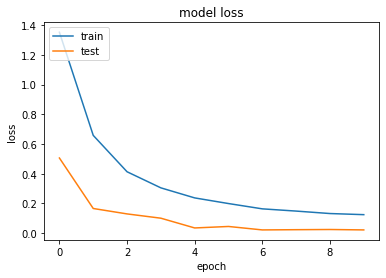

In [ ]:
%matplotlib inline
# summarize history for loss
plt.plot(eff_hist.history['loss'])
plt.plot(eff_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

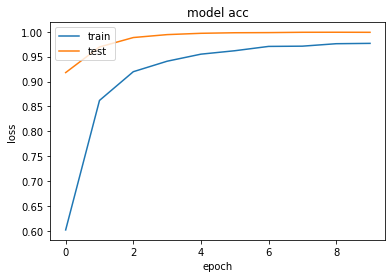

In [ ]:
%matplotlib inline
# summarize history for loss
plt.plot(eff_hist.history['acc'])
plt.plot(eff_hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

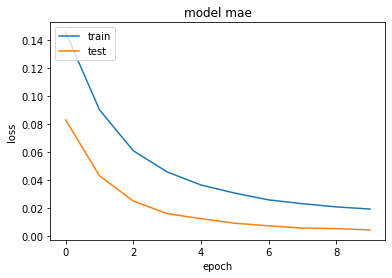

In [ ]:
%matplotlib inline
# summarize history for loss
plt.plot(eff_hist.history['mae'])
plt.plot(eff_hist.history['val_mae'])
plt.title('model mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ef_net.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 32, 32, 64)   1728        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 32, 32, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 32, 32, 64)   0           stem_bn[0][0]                    
____________________________________________________________________________________